# In this notebook I am using Decsion Tree model to clasify wine as red or white
***

I will also compare the results to a Logistic Regression and Knn classifiers at the end to see which model is the best classifier.

In [ ]:
## I like to load all the libraries at the top so I can always check what I have or might need

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier



In [ ]:
### Import our data 

from google.colab import files
data = files.upload()

Saving wine quality data.csv to wine quality data.csv


In [ ]:
### Uploading the data in a pandas dataframe 

wine_df = pd.read_csv('wine quality data.csv', sep=',')
pd.set_option('display.max_columns', None)
print(wine_df.shape)
wine_df.head()


(6497, 13)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [ ]:
round(wine_df.describe(include='all'),2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
count,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,white
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4898
mean,7.22,0.34,0.32,5.44,0.06,30.53,115.74,0.99,3.22,0.53,10.49,5.82,NaN
std,1.30,0.16,0.15,4.76,0.04,17.75,56.52,0.00,0.16,0.15,1.19,0.87,NaN
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,3.00,NaN
25%,6.40,0.23,0.25,1.80,0.04,17.00,77.00,0.99,3.11,0.43,9.50,5.00,NaN
50%,7.00,0.29,0.31,3.00,0.05,29.00,118.00,0.99,3.21,0.51,10.30,6.00,NaN
75%,7.70,0.40,0.39,8.10,0.06,41.00,156.00,1.00,3.32,0.60,11.30,6.00,NaN


In [ ]:
wine_df.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

In [ ]:
### Show the unique values in each column 

df_uniques = pd.DataFrame([[x, len(wine_df[x].unique())] for x in wine_df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques



,Unique Values
Variable,
fixed_acidity,106
volatile_acidity,187
citric_acid,89
residual_sugar,316
chlorides,214
free_sulfur_dioxide,135
total_sulfur_dioxide,276
density,998
pH,108


In [ ]:
### Converting our labels into numerical values of 0 and 1

le = LabelEncoder()

wine_df['color'] = le.fit_transform(wine_df['color'])
wine_df['color'].tail(5)

#wine_df['color'].replace('red', 1).replace('white', 0).astype(np.int) another quick way to do it

6492    1
6493    1
6494    1
6495    1
6496    1
Name: color, dtype: int64

In [ ]:
### Splitting the data into training and testing sets using the stratified method 
### that generates batches of NEXT data to train on - or for Cross validating 


features_columns = [x for x in wine_df.columns if x not in 'color'] 



stratified = StratifiedShuffleSplit(n_splits = 1, test_size=1000)

train_batch, test_batch = next(stratified.split(wine_df[features_columns],wine_df['color']))



x_train = wine_df.loc[train_batch, features_columns]
y_train = wine_df.loc[train_batch, 'color']

x_test = wine_df.loc[test_batch, features_columns]
y_test = wine_df.loc[test_batch, 'color']


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(5497, 12)
(5497,)
(1000, 12)
(1000,)


In [ ]:
### Number of labels in training and testing


print((round(y_test.value_counts(normalize=True).sort_index(),2)) * (y_test.shape[0]))
(round(y_train.value_counts(normalize=True).sort_index(),2)) * (y_train.shape[0])

0    250.0
1    750.0
Name: color, dtype: float64


0    1374.25
1    4122.75
Name: color, dtype: float64

In [ ]:
### Builing the model

wine_dtree = DecisionTreeClassifier().fit(x_train, y_train)
y_predicted = wine_dtree.predict(x_test)

print(f' Number of nodes in the Tree are {wine_dtree.tree_.node_count}')
print(f' The max depth of my Tree is {wine_dtree.tree_.max_depth}')





 Number of nodes in the Tree are 129
 The max depth of my Tree is 16


In [ ]:
### Let's check how accurate our model is! 

accuracy = round(accuracy_score(y_test, y_predicted),2)
f1 = round(f1_score(y_test, y_predicted),2)


print(f'The accuracy is {accuracy}')
print(f'The F1_score is {f1}')


### In the dataframe

df_results = pd.DataFrame([accuracy], columns=['accuracy rate'] ) 
df_results['f1_score'] = f1

df_results.head(5)



The accuracy is 0.98
The F1_score is 0.99


,accuracy rate,f1_score
0,0.98,0.99


In [ ]:
### I will use Grid search next to find the best Tree architecture 


paramaters = {'max_depth':range(1, wine_dtree.tree_.max_depth+1, 2),
              'max_features': range(1, len(wine_dtree.feature_importances_)+1)}

grid_cv = GridSearchCV(DecisionTreeClassifier(),
                  param_grid=paramaters,
                  scoring='accuracy',
                  n_jobs=-1).fit(x_train, y_train)

y_predicted_grid_cv = grid_cv.predict(x_test)



In [ ]:
grid_cv.best_estimator_.tree_.node_count, grid_cv.best_estimator_.tree_.max_depth

(71, 7)

In [ ]:
### The results 


accuracy_cv = round(accuracy_score(y_test, y_predicted_grid_cv),4)
f1_cv = round(f1_score(y_test, y_predicted_grid_cv),4)


print(f'The accuracy is {accuracy_cv}')
print(f'The F1_score is {f1_cv}')


### In the dataframe

df_results_cv = pd.DataFrame([accuracy_cv], columns=['accuracy rate cv'] ) 
df_results_cv['f1_score_cv'] = f1_cv 

df_results_cv.head(5)



The accuracy is 0.978
The F1_score is 0.9855


,accuracy rate cv,f1_score_cv
0,0.978,0.9855


In [ ]:
### Let's try to classify using Logistic Regression and see which model is a better classifier

lr = LogisticRegression(solver ='liblinear').fit(x_train,y_train)

y_predicted_lr = lr.predict(x_test)

accuracy_lr = round(accuracy_score(y_test, y_predicted_lr),4)
f1_lr = round(f1_score(y_predicted_lr, y_test ),4)


print(classification_report(y_test, y_predicted_lr))
print(f'The accuracy of the Logistic Regression model is {accuracy_lr}')
print(f'The F1_score Logistic Regression model is {f1_lr}')

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       246
           1       0.98      0.99      0.99       754

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000

The accuracy of the Logistic Regression model is 0.98
The F1_score Logistic Regression model is 0.9868


In [ ]:
### Let's try to classify using KNN and see which model is a better classifier

from sklearn.neighbors import KNeighborsClassifier

k_value = 40
accuracy_list = []
f1_score_list = []
error_rates_list = []


for x in range(2,40): 
  knn_cv = KNeighborsClassifier(n_neighbors= x, weights='distance').fit(x_train, y_train)
  y_predicted_cv = knn_cv.predict(x_test)
  
  f1_score_list.append((x, round(f1_score(y_predicted_cv, y_test ),3)))
  accuracy_list.append((x, round(accuracy_score(y_test, y_predicted_cv),3)))
  error_rates_list.append((x, 1- round(accuracy_score(y_test, y_predicted_cv),3)))


f1_df_results = pd.DataFrame(f1_score_list,columns=['K Number', 'F1 score'])
accuracy_df = pd.DataFrame(accuracy_list, columns=['K Number','Accuracy rate'])
error_rates_df = pd.DataFrame(error_rates_list, columns=['K Number','Error rate'])
    



In [ ]:
combined_results = pd.concat([f1_df_results, accuracy_df, error_rates_df], axis = 1 )

combined_results.sort_values(['Accuracy rate'], ascending=False).head(15)

### we can see below that at k = 9 we acheived the highest accuracy with KNN 

,K Number,F1 score,K Number,Accuracy rate,K Number,Error rate
12,14,0.974,14,0.960,14,0.040
18,20,0.974,20,0.960,20,0.040
7,9,0.974,9,0.960,9,0.040
8,10,0.974,10,0.960,10,0.040
10,12,0.974,12,0.960,12,0.040
13,15,0.973,15,0.959,15,0.041
16,18,0.973,18,0.959,18,0.041
6,8,0.973,8,0.959,8,0.041
9,11,0.973,11,0.959,11,0.041
11,13,0.973,13,0.959,13,0.041


Text(0.5, 1.0, 'KNN values')

<Figure size 1800x1200 with 0 Axes>

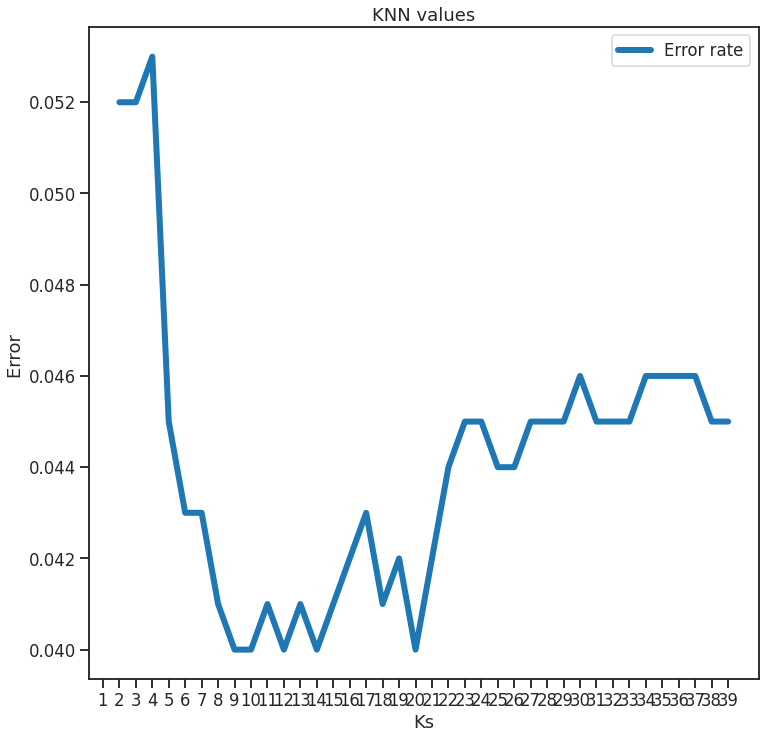

In [ ]:
## I will plot the error rate to confirm the above results visually 

sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_rates_df.set_index('K Number').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='Ks', ylabel='Error ')
ax.set_xticks(range(1, 40, 1))
plt.title('KNN values')

In [ ]:

knn_optimal = KNeighborsClassifier(n_neighbors = 9, weights='distance').fit(x_train,y_train)
y_predicted_knn9 = knn_optimal.predict(x_test)



print(f'The accuracy using KNN CV movel is {round(accuracy_score(y_test, y_predicted_knn9),2)}')
print(f'The accuracy using Decision Tree CV movel is {accuracy_cv}')
print(f'The accuracy of the Logistic Regression model is {accuracy_lr}')


### It's a clear winner here iwith the Logistic Regression model, followed closely by Decision Tree and KNN 4% behind 

The accuracy using KNN CV movel is 0.94
The accuracy using Decision Tree CV movel is 0.978
The accuracy of the Logistic Regression model is 0.98
